Certainly one must be able to shift an ad's display rank in a more sophisticated manner than what we have investigated in the targeted minimum bid strategy. Unfortunately, due to the flat bid strategy used by Acme to produce the data set we're analyzing, we do not have enough information to directly estimate how increasing or lowering an ad's bid will shift its display rank.

Still, we can choose a reasonable figure and then build a model on that assumption as a jumping-off point. To that end, here we will assume that increasing an ad's bid by \\\$2.50 will result in its display ranks improving by one slot (and vice versa for decreasing a bid by \\\$2.50 worsening an ad's display ranks). This is a natural scale for the problem, as the four slot decrease necessary to move all ads down to rank 5 coincides with a \\\$0.00 bid (although here we will again assume that these bids must in fact be \\\$0.01).

Should additional data allow us to refine this assumption and better characterize the bid changes necessary to shift ad rank(s), it will be easy to modify the following code accordingly.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import curve_fit

#Use better looking plot settings
plt.rc('font',family='serif')

#Add nifty official colors
RootOrange = '#FF5715'
Orange120 = '#EE4300'

In [2]:
## Read in the advertising data
RootData = pd.read_csv("Root_Insurance_data.csv")
RootData


,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0
...,...,...,...,...,...,...,...,...
9995,N,1,2,S,10.0,3,True,0
9996,unknown,3,2,M,10.0,3,False,0
9997,Y,3,1,S,10.0,5,False,0
9998,unknown,3,1,M,10.0,3,False,0


In [3]:
#We need this basic information to populate the two parameter space data frames we'll use to build/optimize the model
def basic_info(Category=None, Value=None, RankNum=0, printout=True):
    # Find the clicks per ad, policies sold per ad, and policies sold per click for a subset of the data
    # Return these values, along with their associated uncertainties
    
    if Category==None: #get all the data without cutting on a condition
        ad_clicks = len( RootData.loc[RootData["click"]==True] )
        policies_sold = len( RootData.loc[RootData["policies_sold"]==1] )
        total_ads = len(RootData)
        print(total_ads,'total ads')
        print(ad_clicks,'ad clicks')
        print(policies_sold,'policies sold')
    elif RankNum == 0: #look at only the data specified by the Category and its Value
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[RootData[Category]==Value])
    else: #look at only the data specified by the Category and its Value for rank=RankNum
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[(RootData["rank"]==RankNum) & (RootData[Category]==Value)])
    
    if total_ads > 0:
        clicks_per_ad = ad_clicks/total_ads
        policies_per_ad = policies_sold/total_ads
        policies_per_click = policies_per_ad/clicks_per_ad
        err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
    else:
        return ['---', '---', '---', '---', '---', '---']
    
    if printout == True:
        print(round(clicks_per_ad,3),'+/-',round(err_clicks_per_ad,4),'clicks per ad')
        print(round(policies_per_ad,3),'+/-',round(err_policies_per_ad,4),'policies sold per ad')
        print(round(policies_per_click,3),'+/-',round(err_policies_per_click,4),'policies sold per click')
    
    return [clicks_per_ad, err_clicks_per_ad,
            policies_per_ad, err_policies_per_ad,
            policies_per_click, err_policies_per_click]


In [4]:
#First build a dataframe for the full parameter space of all 35 customer combinations

insured_vals = list( set(RootData["Currently Insured"]) )
vehicles_vals = list( set(RootData["Number of Vehicles"]) )
drivers_vals = list( set(RootData["Number of Drivers"]) )
marital_vals = list( set(RootData["Marital Status"]) )

categories_df = pd.DataFrame({
                        'Insured':[],
                        'Vehicles':[],
                        'Drivers':[],
                        'Marital Status':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                        'Total Clicks':[],
                        'Total Click Uncertainty':[],
                        'Total Policies Sold':[],
                        'Total Policies Sold Uncertainty':[],
                        'Expected Clicks at Rank 5':[],
                        'Uncertainty in Rank 5 Clicks Estimate':[],
                        'Expected Policies Sold at Rank 5':[],
                        'Uncertainty in Rank 5 Sales Estimate':[],
                        'Expected Clicks per Ad':[],
                        'AvgRank':[],
                        'Rank1':[],
                        'Rank2':[],
                        'Rank3':[],
                        'Rank4':[],
                        'Rank5':[]
                        })

#Will need the expected clicks per ad for an ad displayed in ranks 1-5
R1ExpClickPA = basic_info("rank",1,printout=False)[0]
R1ErrClickPa = basic_info("rank",1,printout=False)[1]
R2ExpClickPA = basic_info("rank",2,printout=False)[0]
R2ErrClickPa = basic_info("rank",2,printout=False)[1]
R3ExpClickPA = basic_info("rank",3,printout=False)[0]
R3ErrClickPa = basic_info("rank",3,printout=False)[1]
R4ExpClickPA = basic_info("rank",4,printout=False)[0]
R4ErrClickPa = basic_info("rank",4,printout=False)[1]
R5ExpClickPA = basic_info("rank",5,printout=False)[0]
R5ErrClickPa = basic_info("rank",5,printout=False)[1]

for insured_val in insured_vals:
    for vehicles_val in vehicles_vals:
        for drivers_val in drivers_vals:
            for marital_val in marital_vals:
                Ranks = [ len(RootData.loc[(RootData["rank"]==i+1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)]) for i in range(5) ]
                ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                total_ads = len(RootData.loc[(RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                if (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4]) > 0:
                    #probably best to just leave out the empty unknown/3/2/S bin that has no ads
                    #which is what this if statement does
                    
                    clicks_per_ad = ad_clicks/total_ads
                    policies_per_ad = policies_sold/total_ads
                    policies_per_click = policies_per_ad/clicks_per_ad
                    
                    err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
                    
                    ExpClickTot = R1ExpClickPA*Ranks[0] + R2ExpClickPA*Ranks[1] + R3ExpClickPA*Ranks[2] + R4ExpClickPA*Ranks[3] + R5ExpClickPA*Ranks[4]
                    AvgRank = ( 1*Ranks[0]+2*Ranks[1]+3*Ranks[2]+4*Ranks[3]+5*Ranks[4] ) / (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ExpClickperAd = ExpClickTot/sum(Ranks)
                    
                    #Number of expected clicks if we were to place all ads for customers of these traits in rank 5
                    ExpClickR5 = R5ExpClickPA*(Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ErrClickR5 = ExpClickR5*np.sqrt(R5ErrClickPa**2)
                    ExpPoliciesR5 = policies_per_click*ExpClickR5
                    ErrPoliciesR5 = ExpPoliciesR5 * np.sqrt( (err_policies_per_click/policies_per_click)**2 + (ErrClickR5/ExpClickR5)**2 )
                    
                    #print(insured_val, vehicles_val, drivers_val, marital_val, AvgRank_Val, policies_per_click)
                    new_row = {'Insured':insured_val, 'Vehicles':vehicles_val, 'Drivers':drivers_val,
                               'Marital Status':marital_val, 'Policies Sold per Click':policies_per_click,
                               'Policies Sold per Click Uncertainty':err_policies_per_click,
                               'Total Clicks':ad_clicks, 'Total Click Uncertainty':np.sqrt(ad_clicks),
                               'Total Policies Sold':policies_sold, 'Total Policies Sold Uncertainty':np.sqrt(policies_sold),
                               'Expected Clicks at Rank 5':ExpClickR5, 'Uncertainty in Rank 5 Clicks Estimate':ErrClickR5,
                               'Expected Policies Sold at Rank 5':ExpPoliciesR5,'Uncertainty in Rank 5 Sales Estimate':ErrPoliciesR5,
                               'Expected Clicks per Ad':ExpClickperAd, 'AvgRank':AvgRank,
                               'Rank1':Ranks[0],'Rank2':Ranks[1], 'Rank3':Ranks[2],'Rank4':Ranks[3], 'Rank5':Ranks[4]
                               }
                    categories_df = categories_df.append(new_row, ignore_index=True)

categories_df = categories_df.sort_values(by=['Policies Sold per Click'], ascending=False).reset_index(drop=True)
categories_df


,Insured,Vehicles,Drivers,Marital Status,Policies Sold per Click,Policies Sold per Click Uncertainty,Total Clicks,Total Click Uncertainty,Total Policies Sold,Total Policies Sold Uncertainty,...,Uncertainty in Rank 5 Clicks Estimate,Expected Policies Sold at Rank 5,Uncertainty in Rank 5 Sales Estimate,Expected Clicks per Ad,AvgRank,Rank1,Rank2,Rank3,Rank4,Rank5
0,N,3.0,1.0,M,0.600000,0.258296,15.0,3.872983,9.0,3.000000,...,0.017502,3.400698,1.464017,0.063673,4.305660,0.0,0.0,51.0,82.0,132.0
1,N,1.0,1.0,S,0.581395,0.154520,43.0,6.557439,25.0,5.000000,...,0.017898,3.369860,0.895682,0.135176,3.435424,0.0,59.0,84.0,79.0,49.0
2,N,1.0,1.0,M,0.560000,0.192444,25.0,5.000000,14.0,3.741657,...,0.019813,3.593191,1.234849,0.123254,3.573333,0.0,53.0,87.0,95.0,65.0
3,unknown,1.0,1.0,S,0.543307,0.093331,127.0,11.269428,69.0,8.306624,...,0.018493,3.253677,0.559019,0.392509,1.621429,148.0,90.0,42.0,0.0,0.0
4,unknown,1.0,2.0,M,0.542857,0.099907,105.0,10.246951,57.0,7.549834,...,0.019417,3.413531,0.628312,0.386952,1.659864,155.0,84.0,55.0,0.0,0.0
5,unknown,1.0,1.0,M,0.526786,0.095231,112.0,10.583005,59.0,7.681146,...,0.019417,3.312473,0.598907,0.380966,1.690476,150.0,85.0,59.0,0.0,0.0
6,N,3.0,2.0,M,0.523810,0.199229,21.0,4.582576,11.0,3.316625,...,0.021531,3.652262,1.389169,0.067401,4.245399,0.0,0.0,71.0,104.0,151.0
7,unknown,2.0,1.0,M,0.488095,0.102101,84.0,9.165151,41.0,6.403124,...,0.017700,2.797759,0.585309,0.365601,1.761194,122.0,88.0,58.0,0.0,0.0
8,Y,1.0,1.0,S,0.487179,0.104526,78.0,8.831761,38.0,6.164414,...,0.019153,3.021746,0.648391,0.246573,2.548276,60.0,74.0,93.0,63.0,0.0
9,N,2.0,2.0,S,0.468750,0.151346,32.0,5.656854,15.0,3.872983,...,0.020870,3.168103,1.022936,0.117588,3.632911,0.0,48.0,94.0,100.0,74.0


In [5]:
#We'll want to have a compressed parameter space when we're optimizing the model, since having 35 combinations
#is unfeasibly large given that we will have at least 9 bid prices to investigate per combination.

#We'll start by combining No & Unknown Insurance,
#since these subcategories have similar policies sold per click measurements
#And the same goes for 2 & 3 Vehicles

#Combine Not Insured and Unknown Insurance status
RootData.loc[RootData["Currently Insured"] == "unknown", "Currently Insured"] = "U/N"
RootData.loc[RootData["Currently Insured"] == "N", "Currently Insured"] = "U/N"

#Combine all >1 Number of Vehicle customers
RootData.loc[RootData["Number of Vehicles"] == 2, "Number of Vehicles"] = 23
RootData.loc[RootData["Number of Vehicles"] == 3, "Number of Vehicles"] = 23

RootData

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,U/N,23,1,M,10.0,2,False,0
1,Y,23,1,M,10.0,5,False,0
2,Y,23,2,M,10.0,5,False,0
3,U/N,23,2,S,10.0,4,False,0
4,U/N,23,2,S,10.0,2,False,0
...,...,...,...,...,...,...,...,...
9995,U/N,1,2,S,10.0,3,True,0
9996,U/N,23,2,M,10.0,3,False,0
9997,Y,23,1,S,10.0,5,False,0
9998,U/N,23,1,M,10.0,3,False,0


In [6]:
#In addition to the two combinations made above, we'll ignore marital status when making
#the compressed parameter space, since it seems to be an unimportant feature

#Ultimately this will compress the parameter space from 35 combinations down to 8

insured_vals = list( set(RootData["Currently Insured"]) )
vehicles_vals = list( set(RootData["Number of Vehicles"]) )
drivers_vals = list( set(RootData["Number of Drivers"]) )

compressed_df = pd.DataFrame({
                        'Insured':[],
                        'Vehicles':[],
                        'Drivers':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                        'Total Clicks':[],
                        'Total Click Uncertainty':[],
                        'Total Policies Sold':[],
                        'Total Policies Sold Uncertainty':[],
                        'Expected Clicks at Rank 5':[],
                        'Uncertainty in Rank 5 Clicks Estimate':[],
                        'Expected Policies Sold at Rank 5':[],
                        'Uncertainty in Rank 5 Sales Estimate':[],
                        'Expected Clicks per Ad':[],
                        'AvgRank':[],
                        'Rank1':[],
                        'Rank2':[],
                        'Rank3':[],
                        'Rank4':[],
                        'Rank5':[]
                        })

for insured_val in insured_vals:
    for vehicles_val in vehicles_vals:
        for drivers_val in drivers_vals:
            Ranks = [ len(RootData.loc[(RootData["rank"]==i+1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ]) for i in range(5) ]
            ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ])
            policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ])
            total_ads = len(RootData.loc[(RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) ])
            if (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4]) > 0:
                #probably best to just leave out the empty unknown/3/2/S bin that has no ads
                #which is what this if statement does

                clicks_per_ad = ad_clicks/total_ads
                policies_per_ad = policies_sold/total_ads
                policies_per_click = policies_per_ad/clicks_per_ad

                err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
                err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
                err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )

                ExpClickTot = R1ExpClickPA*Ranks[0] + R2ExpClickPA*Ranks[1] + R3ExpClickPA*Ranks[2] + R4ExpClickPA*Ranks[3] + R5ExpClickPA*Ranks[4]
                AvgRank = ( 1*Ranks[0]+2*Ranks[1]+3*Ranks[2]+4*Ranks[3]+5*Ranks[4] ) / (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                ExpClickperAd = ExpClickTot/sum(Ranks)

                #Number of expected clicks if we were to place all ads for customers of these traits in rank 5
                ExpClickR5 = R5ExpClickPA*(Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                ErrClickR5 = ExpClickR5*np.sqrt(R5ErrClickPa**2)
                ExpPoliciesR5 = policies_per_click*ExpClickR5
                ErrPoliciesR5 = ExpPoliciesR5 * np.sqrt( (err_policies_per_click/policies_per_click)**2 + (ErrClickR5/ExpClickR5)**2 )

                #print(insured_val, vehicles_val, drivers_val, marital_val, AvgRank_Val, policies_per_click)
                new_row = {'Insured':insured_val, 'Vehicles':vehicles_val, 'Drivers':drivers_val,
                           'Policies Sold per Click':policies_per_click,
                           'Policies Sold per Click Uncertainty':err_policies_per_click,
                           'Total Clicks':ad_clicks, 'Total Click Uncertainty':np.sqrt(ad_clicks),
                           'Total Policies Sold':policies_sold, 'Total Policies Sold Uncertainty':np.sqrt(policies_sold),
                           'Expected Clicks at Rank 5':ExpClickR5, 'Uncertainty in Rank 5 Clicks Estimate':ErrClickR5,
                           'Expected Policies Sold at Rank 5':ExpPoliciesR5,'Uncertainty in Rank 5 Sales Estimate':ErrPoliciesR5,
                           'Expected Clicks per Ad':ExpClickperAd, 'AvgRank':AvgRank,
                           'Rank1':Ranks[0],'Rank2':Ranks[1], 'Rank3':Ranks[2],'Rank4':Ranks[3], 'Rank5':Ranks[4]
                           }
                compressed_df = compressed_df.append(new_row, ignore_index=True)

compressed_df = compressed_df.sort_values(by=['Policies Sold per Click'], ascending=False).reset_index(drop=True)
compressed_df


,Insured,Vehicles,Drivers,Policies Sold per Click,Policies Sold per Click Uncertainty,Total Clicks,Total Click Uncertainty,Total Policies Sold,Total Policies Sold Uncertainty,Expected Clicks at Rank 5,Uncertainty in Rank 5 Clicks Estimate,Expected Policies Sold at Rank 5,Uncertainty in Rank 5 Sales Estimate,Expected Clicks per Ad,AvgRank,Rank1,Rank2,Rank3,Rank4,Rank5
0,U/N,1.0,1.0,0.543974,0.057032,307.0,17.521415,167.0,12.922848,24.489306,0.075621,13.321544,1.397278,0.258092,2.579913,298.0,287.0,272.0,174.0,114.0
1,U/N,1.0,2.0,0.453368,0.045420,386.0,19.646883,175.0,13.228757,24.703186,0.076282,11.199631,1.122541,0.323762,2.046753,433.0,332.0,293.0,97.0,0.0
2,Y,1.0,1.0,0.426087,0.076991,115.0,10.723805,49.0,7.000000,12.062855,0.037249,5.139825,0.928865,0.187023,3.044326,60.0,124.0,172.0,147.0,61.0
3,U/N,23.0,1.0,0.414141,0.040450,396.0,19.899749,164.0,12.806248,46.647316,0.144044,19.318585,1.887828,0.187078,3.213205,367.0,329.0,508.0,426.0,551.0
4,U/N,23.0,2.0,0.382979,0.039349,376.0,19.390719,144.0,12.000000,44.914884,0.138694,17.201445,1.768149,0.195170,3.100000,346.0,369.0,534.0,431.0,420.0
5,Y,1.0,2.0,0.313725,0.055090,153.0,12.369317,48.0,6.928203,12.340899,0.038108,3.871655,0.679969,0.244658,2.535529,107.0,167.0,190.0,113.0,0.0
6,Y,23.0,2.0,0.257576,0.070863,66.0,8.124038,17.0,4.123106,24.959843,0.077074,6.429050,1.768846,0.062062,4.331620,0.0,0.0,211.0,358.0,598.0
7,Y,23.0,1.0,0.240506,0.062295,79.0,8.888194,19.0,4.358899,23.762113,0.073376,5.714938,1.480373,0.064439,4.293429,0.0,0.0,221.0,343.0,547.0


In order to get useful information from this model, we need a function that will output the expected sales when we change our bid for a given customer demographic. Here we will also be clever and build the function such that it will not allow us to make a \\\$20 bid if a \\\$17.50 bid already moves all of a demographic's ads to rank 1. It will similarly save us from making unnecesary bids above \\\$0.01 if these higher bids would not yield improved display ranks.

In [7]:
#This is the amount (in dollars) that we are assuming will increase a bid's rank placement by 1 spot
RankValue = 2.50

# We'll again assume that the lowest possible bid one can make is $0.01,
# since I doubt the search host would let you bid $0.00
MinBidVal = 0.01


In [8]:
def UpdatedBidInfo(cat_df, cat_ind, NewBid, printout=True):
    #Figure out how ad clicks and subsequent policy sales change when the $10 bid is changed to NewBid
    #This assumes that increasing a bid by RankValue will shift the ad up one rank
    #And that this shift will proceed linearly between the integer multiples of RankVal
    #I.e., increasing a bid by 0.5*RankValue will shift half of the ads up one rank
    
    i = cat_ind #the index of the entry in categories_df
    
    if (NewBid <= 10.00+4.0*RankValue) and (NewBid > 10.00+3.0*RankValue):
        frac = (NewBid - (10.00+3.0*RankValue)) / RankValue
        Rank1s = cat_df.iloc[i]["Rank1"]+cat_df.iloc[i]["Rank2"]+cat_df.iloc[i]["Rank3"]
        Rank1s +=cat_df.iloc[i]["Rank4"]+cat_df.iloc[i]["Rank5"]*frac
        Rank2s = cat_df.iloc[i]["Rank5"]*(1.0-frac)
        Rank3s = 0
        Rank4s = 0
        Rank5s = 0
    elif (NewBid <= 10.00+3.0*RankValue) and (NewBid > 10.00+2.0*RankValue):
        frac = (NewBid - (10.00+2.0*RankValue)) / RankValue
        Rank1s = cat_df.iloc[i]["Rank1"]+cat_df.iloc[i]["Rank2"]+cat_df.iloc[i]["Rank3"]
        Rank1s +=cat_df.iloc[i]["Rank4"]*frac
        Rank2s = cat_df.iloc[i]["Rank5"]*frac+cat_df.iloc[i]["Rank4"]*(1.0-frac)
        Rank3s = cat_df.iloc[i]["Rank5"]*(1.0-frac)
        Rank4s = 0
        Rank5s = 0
    elif (NewBid <= 10.00+2.0*RankValue) and (NewBid > 10.00+1.0*RankValue):
        frac = (NewBid - (10.00+1.0*RankValue)) / RankValue
        Rank1s = cat_df.iloc[i]["Rank1"]+cat_df.iloc[i]["Rank2"]+cat_df.iloc[i]["Rank3"]*frac
        Rank2s = cat_df.iloc[i]["Rank4"]*frac+cat_df.iloc[i]["Rank3"]*(1.0-frac)
        Rank3s = cat_df.iloc[i]["Rank5"]*frac+cat_df.iloc[i]["Rank4"]*(1.0-frac)
        Rank4s = cat_df.iloc[i]["Rank5"]*(1.0-frac)
        Rank5s = 0
    elif (NewBid <= 10.00+1.0*RankValue) and (NewBid > 10.00):
        frac = (NewBid - 10.00) / RankValue
        Rank1s = cat_df.iloc[i]["Rank1"]+cat_df.iloc[i]["Rank2"]*frac
        Rank2s = cat_df.iloc[i]["Rank3"]*frac+cat_df.iloc[i]["Rank2"]*(1.0-frac)
        Rank3s = cat_df.iloc[i]["Rank4"]*frac+cat_df.iloc[i]["Rank3"]*(1.0-frac)
        Rank4s = cat_df.iloc[i]["Rank5"]*frac+cat_df.iloc[i]["Rank4"]*(1.0-frac)
        Rank5s = cat_df.iloc[i]["Rank5"]*(1.0-frac)
    elif (NewBid <= 10.00) and (NewBid > 10.00-1.0*RankValue):
        frac = (NewBid - (10.00-1.0*RankValue)) / RankValue
        Rank1s = cat_df.iloc[i]["Rank1"]*frac
        Rank2s = cat_df.iloc[i]["Rank2"]*frac+cat_df.iloc[i]["Rank1"]*(1.0-frac)
        Rank3s = cat_df.iloc[i]["Rank3"]*frac+cat_df.iloc[i]["Rank2"]*(1.0-frac)
        Rank4s = cat_df.iloc[i]["Rank4"]*frac+cat_df.iloc[i]["Rank3"]*(1.0-frac)
        Rank5s = cat_df.iloc[i]["Rank5"]+cat_df.iloc[i]["Rank4"]*(1.0-frac)
    elif (NewBid <= 10.00-1.0*RankValue) and (NewBid > 10.00-2.0*RankValue):
        frac = (NewBid - (10.00-2.0*RankValue)) / RankValue
        Rank1s = 0
        Rank2s = cat_df.iloc[i]["Rank1"]*frac
        Rank3s = cat_df.iloc[i]["Rank2"]*frac+cat_df.iloc[i]["Rank1"]*(1.0-frac)
        Rank4s = cat_df.iloc[i]["Rank3"]*frac+cat_df.iloc[i]["Rank2"]*(1.0-frac)
        Rank5s = cat_df.iloc[i]["Rank5"]+cat_df.iloc[i]["Rank4"]+cat_df.iloc[i]["Rank3"]*(1.0-frac)
    elif (NewBid <= 10.00-2.0*RankValue) and (NewBid > 10.00-3.0*RankValue):
        frac = (NewBid - (10.00-3.0*RankValue)) / RankValue
        Rank1s = 0
        Rank2s = 0
        Rank3s = cat_df.iloc[i]["Rank1"]*frac
        Rank4s = cat_df.iloc[i]["Rank2"]*frac+cat_df.iloc[i]["Rank1"]*(1.0-frac)
        Rank5s = cat_df.iloc[i]["Rank5"]+cat_df.iloc[i]["Rank4"]+cat_df.iloc[i]["Rank3"]
        Rank5s +=cat_df.iloc[i]["Rank2"]*(1.0-frac)
    elif (NewBid <= 10.00-3.0*RankValue) and (NewBid > 10.00-4.0*RankValue):
        frac = (NewBid - (10.00-4.0*RankValue)) / RankValue
        Rank1s = 0
        Rank2s = 0
        Rank3s = 0
        Rank4s = cat_df.iloc[i]["Rank1"]*frac
        Rank5s = cat_df.iloc[i]["Rank5"]+cat_df.iloc[i]["Rank4"]+cat_df.iloc[i]["Rank3"]
        Rank5s +=cat_df.iloc[i]["Rank2"]+cat_df.iloc[i]["Rank1"]*(1.0-frac)
    elif NewBid <= 10.00-4.0*RankValue:
        #These will include MinBidVal bids
        Rank1s = 0
        Rank2s = 0
        Rank3s = 0
        Rank4s = 0
        Rank5s = cat_df.iloc[i]["Rank5"]+cat_df.iloc[i]["Rank4"]+cat_df.iloc[i]["Rank3"]
        Rank5s +=cat_df.iloc[i]["Rank2"]+cat_df.iloc[i]["Rank1"]

    ExpClickTot = R1ExpClickPA*Rank1s+R2ExpClickPA*Rank2s+R3ExpClickPA*Rank3s+R4ExpClickPA*Rank4s+R5ExpClickPA*Rank5s
    if Rank1s > 0:
        R1ClickTotErr = R1ExpClickPA*Rank1s * np.sqrt( (R1ErrClickPa/R1ExpClickPA)**2.0 + (np.sqrt(Rank1s)/Rank1s)**2.0 )
    else:
        R1ClickTotErr = 0
    if Rank2s > 0:
        R2ClickTotErr = R2ExpClickPA*Rank2s * np.sqrt( (R2ErrClickPa/R2ExpClickPA)**2.0 + (np.sqrt(Rank2s)/Rank2s)**2.0 )
    else:
        R2ClickTotErr = 0
    if Rank3s > 0:
        R3ClickTotErr = R3ExpClickPA*Rank3s * np.sqrt( (R3ErrClickPa/R3ExpClickPA)**2.0 + (np.sqrt(Rank3s)/Rank3s)**2.0 )
    else:
        R3ClickTotErr = 0
    if Rank4s > 0:
        R4ClickTotErr = R4ExpClickPA*Rank4s * np.sqrt( (R4ErrClickPa/R4ExpClickPA)**2.0 + (np.sqrt(Rank4s)/Rank4s)**2.0 )
    else:
        R4ClickTotErr = 0
    if Rank5s > 0:
        R5ClickTotErr = R5ExpClickPA*Rank5s * np.sqrt( (R5ErrClickPa/R5ExpClickPA)**2.0 + (np.sqrt(Rank5s)/Rank5s)**2.0 )
    else:
        R5ClickTotErr = 0
    ExpClickTotErr = np.sqrt( R1ClickTotErr**2.0+R2ClickTotErr**2.0+R3ClickTotErr**2.0+R4ClickTotErr**2.0+R5ClickTotErr**2.0 )
    
    PSpC = cat_df.iloc[i]["Policies Sold per Click"]
    PspC_Err = cat_df.iloc[i]["Policies Sold per Click Uncertainty"]
    PoliciesSold = ExpClickTot*PSpC
    PoliciesSoldErr = PoliciesSold * np.sqrt( (ExpClickTotErr/ExpClickTot)**2 + (PspC_Err/PSpC)**2  )
    
    #Directly take the Total Policies Sold and associated uncertainty from known $10 bid data
    if NewBid == 10.00:
        ExpClickTot = cat_df.iloc[i]["Total Clicks"]
        ExpClickTotErr = cat_df.iloc[i]["Total Click Uncertainty"]
        PoliciesSold = cat_df.iloc[i]["Total Policies Sold"]
        PoliciesSoldErr = cat_df.iloc[i]["Total Policies Sold Uncertainty"]
    
    #Deal with cases where increasing/decreasing the bid has no impact
    #I.e., no need to pay a maximum bid if the $10 bid never resulted in a placement lower than Rank 3
    #In this case we would have already placed all ads in this customer combo into Rank 1 by bidding $10+2*RankVal
    TrueBid = NewBid
    if (cat_df.iloc[i]["Rank1"]==0) and (cat_df.iloc[i]["Rank2"]==0):
        if (NewBid <= 10.00-2.0*RankValue):
            TrueBid = MinBidVal
    elif (cat_df.iloc[i]["Rank1"]==0):
        if (NewBid <= 10.00-3.0*RankValue):
            TrueBid = MinBidVal
    elif (cat_df.iloc[i]["Rank5"]==0) and (cat_df.iloc[i]["Rank4"]==0):
        if (NewBid >= 10.00+2.0*RankValue):
            TrueBid = 10.00+2.0*RankValue
    elif (cat_df.iloc[i]["Rank5"]==0):
        if (NewBid >= 10.00+3.0*RankValue):
            TrueBid = 10.00+3.0*RankValue
        
    if printout==True:
        print(cat_df.iloc[i]["Insured"],'\t',
              cat_df.iloc[i]["Vehicles"],'\t',
              cat_df.iloc[i]["Drivers"],'\t',
              cat_df.iloc[i]["Marital Status"],'\t',
              Rank1s+Rank2s+Rank3s+Rank4s+Rank5s,'\t',
              round(PSpC,3),'\t',
              NewBid,'\t',
              TrueBid,'\t',
              round(PoliciesSold,2),'\t',
              round(ExpClickTot,1))

    return PoliciesSold, ExpClickTot, TrueBid


We'll now extend that model to get the statistics for a bid strategy based on the list of bids used for each customer demographic.

In [9]:
def BidStrategyStats(cat_df, BidValues, printout=True):
    #Given a set of bids, predict how many sales will be made and how much each will cost
    
    if not len(BidValues)==len(cat_df):
        print("Error. BidValues must contain a bid prescription for each customer combination.")
        return
    
    TotalAdCost = 0.0
    PolicySales = []
    AdClicks = []
    TrueBids = []
    for i in range(len(cat_df)):
        Bid = BidValues[i]
        SalesNum, AdClick, TrueBid = UpdatedBidInfo(cat_df, i, Bid, printout=False)
        TotalAdCost += TrueBid*AdClick
        PolicySales.append(SalesNum)
        AdClicks.append(AdClick)
        TrueBids.append(TrueBid)
    
    PolicySales = sum(PolicySales)
    CostPerAd = TotalAdCost/PolicySales
    
    if printout == True:
        print(round(CostPerAd,2),'\t',
              round(PolicySales,1),'\t',
              TrueBids)
    
    return(CostPerAd,PolicySales,TrueBids)

We need to explore this model to get a handle on how best to utilize it/how to optimize strategies within the model framework. To do so, we'll build a couple subsamples in the compressed parameter space, since exploring the full space would require some $9^8$ computations and take 12 hours or so to compute. We'll also look at a series of flat-bid strategies to see how they compare.

Note that these calculations are still rather slow and computaitonally intensive, so they may take several hours to finish.

In [10]:
#The 9 natural bid prices to investigate
#PossibleBids = np.array([10.00+4.0*RankValue, 10.00+3.0*RankValue, 10.00+2.0*RankValue, 10.00+1.0*RankValue,
#                         10.00, 10.00-1.0*RankValue, 10.00-2.0*RankValue, 10.00-3.0*RankValue, MinBidVal])

#Sparser subset of PossibleBids that we'll use to make calculation faster
PossibleBids = np.array([10.00+4.0*RankValue, 10.00+2.0*RankValue, 10.00, 10.00-2.0*RankValue, MinBidVal])


AdCosts = []
TotSales = []
SetBids = []

for s0_i in range(len(PossibleBids)):
    for s1_i in range(len(PossibleBids)):
        for s2_i in range(len(PossibleBids)):
            for s3_i in range(len(PossibleBids)):
                for s4_i in range(len(PossibleBids)):
                    for s5_i in range(len(PossibleBids)):
                        for s6_i in range(len(PossibleBids)):
                            for s7_i in range(len(PossibleBids)):
                                TestBids = [PossibleBids[s0_i],
                                            PossibleBids[s1_i],
                                            PossibleBids[s2_i],
                                            PossibleBids[s3_i],
                                            PossibleBids[s4_i],
                                            PossibleBids[s5_i],
                                            PossibleBids[s6_i],
                                            PossibleBids[s7_i]]
                                AdCost, TotSale, TrueBids = BidStrategyStats(compressed_df, TestBids, printout=False)
                                SetBids.append(TrueBids)
                                AdCosts.append(AdCost)
                                TotSales.append(TotSale)


In [11]:
#Sample another subset of the full PossibleBids space to get a more complete picture of the model
PossibleBids = np.array([10.00+3.0*RankValue, 10.00+1.0*RankValue, 10.00, 10.00-1.0*RankValue, 10.00-3.0*RankValue])

for s0_i in range(len(PossibleBids)):
    for s1_i in range(len(PossibleBids)):
        for s2_i in range(len(PossibleBids)):
            for s3_i in range(len(PossibleBids)):
                for s4_i in range(len(PossibleBids)):
                    for s5_i in range(len(PossibleBids)):
                        for s6_i in range(len(PossibleBids)):
                            for s7_i in range(len(PossibleBids)):
                                TestBids = [PossibleBids[s0_i],
                                            PossibleBids[s1_i],
                                            PossibleBids[s2_i],
                                            PossibleBids[s3_i],
                                            PossibleBids[s4_i],
                                            PossibleBids[s5_i],
                                            PossibleBids[s6_i],
                                            PossibleBids[s7_i]]
                                AdCost, TotSale, TrueBids = BidStrategyStats(compressed_df, TestBids, printout=False)
                                SetBids.append(TrueBids)
                                AdCosts.append(AdCost)
                                TotSales.append(TotSale)


In [12]:
#Get a list of the continuum of constant-bid strategies
ConstSetBids = []
ConstAdCosts = []
ConstTotSales = []

MorePossibleBids = np.append(
    np.linspace(10.00+4.0*RankValue,10.00-4.0*RankValue,num=6000,endpoint=False),
    np.array([MinBidVal])
    )

for i in range(len(MorePossibleBids)):
    AdCost, TotSale, TrueBids = BidStrategyStats(compressed_df, [MorePossibleBids[i]]*8, printout=False)
    ConstSetBids.append(TrueBids)
    ConstAdCosts.append(AdCost)
    ConstTotSales.append(TotSale)

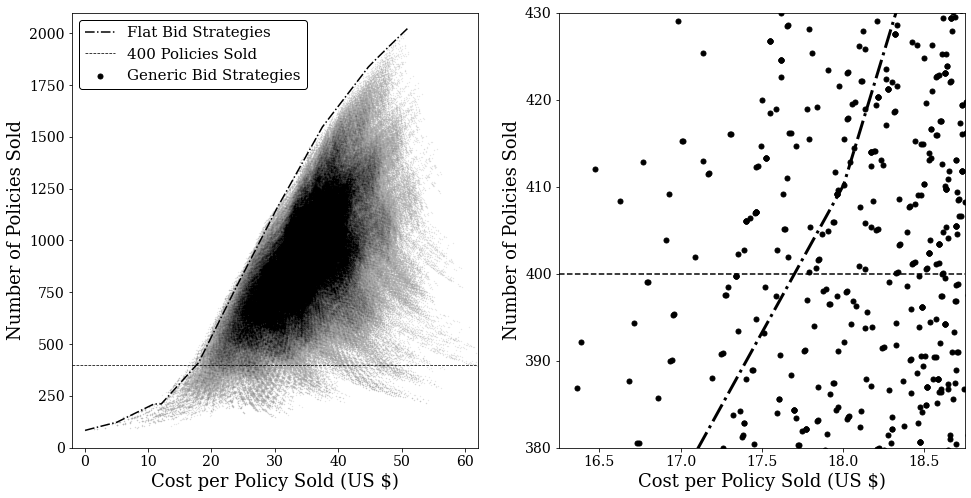

In [13]:
plt.figure(figsize=(16,8))

#Plot full space
plt.subplot(1,2,1)

#putting a point off in the middle of nowhere to have a visible entry in the legend
plt.scatter(500, 5000, color='k', label='Generic Bid Strategies', s=25)

plt.scatter(AdCosts, TotSales, color='0.8', s=0.025)
plt.scatter(AdCosts, TotSales, color='k', s=0.5, alpha=0.006)
plt.plot(ConstAdCosts, ConstTotSales, color='k', label='Flat Bid Strategies', linewidth=1.5, linestyle='-.')
plt.axhline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

plt.legend(fontsize=15,loc='upper left',framealpha=1.0,edgecolor='k')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-2.00,62.00)
plt.ylim(0,2100)


#Now zoom in around the 400 policies sold region
plt.subplot(1,2,2)

plt.scatter(AdCosts, TotSales, color='k', label='Generic Bid Strategies', s=25)
plt.plot(ConstAdCosts, ConstTotSales, color='k', label='Flat Bid Strategies', linewidth=3.0, linestyle='-.')
plt.axhline(400,color='k',linestyle='--',label='400 Policies Sold',linewidth=1.5)

plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(16.25,18.75)
plt.ylim(380,430)

plt.show()

Thus, if our assumption that changing our bid by \\\$2.50 will shift an ad's rank by 1 is valid, then we can obtain 400 expected policy sales at an ad cost of about \\\$17.70 per policy sold if we bid a flat \\\$7.37 for each customer. This would be a considerable savings of over 25\% compared to the current flat \\\$10 bid strategy, which costs \\\$23.98 per policy sold.

Somewhat surprisingly, the curve of flat-bid strategies seems to trace out a nearly-optimal limit. Generic bid strategies almost always do worse than this limit (i.e., yield less policies for a chosen cost per sale), as shown by the cloud of gray points produced by randomly selecting bid prices. It's notable that there are a handful of mixed bid strategies that slightly outperform the curve of constant bidding (see the few points above the dot-dashed curve in the right panel), but rigorously exploring all of parameter space to find a handful of slight improvements would be quite inefficient and time-consuming.

However, if we take a little random walk...

In [14]:
#Let's build a random walker that will start from the curve of flat bidding and move to a more optimized strategy

#Get a list of the continuum of constant-bid strategies
ConstSetBids = []
ConstAdCosts = []
ConstTotSales = []

MorePossibleBids = np.append(
    np.linspace(10.00+4.0*RankValue,10.00-4.0*RankValue,num=6000,endpoint=False),
    np.array([MinBidVal])
    )

for i in range(len(MorePossibleBids)):
    AdCost, TotSale, TrueBids = BidStrategyStats(compressed_df, [MorePossibleBids[i]]*8, printout=False)
    ConstSetBids.append(TrueBids)
    ConstAdCosts.append(AdCost)
    ConstTotSales.append(TotSale)

In [15]:
#Identify the flat-bid strategy that offers the cheapest route to 400 sales

opt_ind = [i for i,x in enumerate(ConstTotSales) if x>400][-1]
BidsToHitGoal = ConstSetBids[opt_ind]
print("The following bid strategy is expected to yield "+str(round(ConstTotSales[opt_ind],1))+" policy sales, at a cost per policy of $"+str(round(ConstAdCosts[opt_ind],2))+"." )
print()

for i in range(len(BidsToHitGoal)):
    CustomerInfo = categories_df.iloc[i][["Insured","Vehicles","Drivers"]].values
    CustomerInfo = np.where(CustomerInfo == 23, '2/3', CustomerInfo)
    print("Insured: "+str(CustomerInfo[0]),'\t',
          "Vehicles: "+str(CustomerInfo[1]),'\t',
          "Drivers: "+str(CustomerInfo[2]),'\t',
          "Marital Status: "+"M/S",'\t',
          "Bid: $"+str(round(BidsToHitGoal[i],2)),
         )

print()
print("This is where we will start our random walk optimization process.")

The following bid strategy is expected to yield 400.1 policy sales, at a cost per policy of $17.7.

Insured: N 	 Vehicles: 3.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: N 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: N 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: unknown 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: unknown 	 Vehicles: 1.0 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: unknown 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: N 	 Vehicles: 3.0 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $7.37
Insured: unknown 	 Vehicles: 2.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $7.37

This is where we will start our random walk optimization process.


In [16]:
def RandomWalker(SalesGoal, NSteps, DistWidth=0.2, cat_df=compressed_df, printout=False, OptimalStrategy=[], OptimalCost=99.9, OptimalSales=1.0):
    
    if OptimalStrategy==[]:
        #Start by finding the flat-bid strategy that satisfies your sales goal
        #This is skipped if a different initial starting strategy is provided
        opt_ind = [i for i,x in enumerate(ConstTotSales) if x>float(SalesGoal)][-1]
        OptimalStrategy = np.array(ConstSetBids[opt_ind])
        OptimalCost = ConstAdCosts[opt_ind]
        OptimalSales = ConstTotSales[opt_ind]
    
    for i in range(NSteps):
        #Take a random step from the previous best strategy drawn using a distribution with a sigma of RankValue*DistWidth
        NewStrategy = np.array(OptimalStrategy) + np.random.normal(0.0, RankValue*DistWidth, len(OptimalStrategy) )
        
        #Can't have bids below MinBidVal
        #Don't want bids above 10.00+4.0*RankValue
        for i in range(len(NewStrategy)):
            if NewStrategy[i] < MinBidVal:
                NewStrategy[i] = MinBidVal
            elif NewStrategy[i] > 10.00+4.0*RankValue:
                NewStrategy[i] = 10.00+4.0*RankValue
        
        AdCost, TotSale, TrueBids = BidStrategyStats(cat_df, NewStrategy, printout=False)
        #Update best strategy if the random step produced an improvement, otherwise ignore it
        if AdCost < OptimalCost and TotSale >= SalesGoal:
            OptimalCost = AdCost
            OptimalSales = TotSale
            OptimalStrategy = TrueBids
    
    if printout==True:
        print(round(OptimalCost,2), '\t', round(OptimalSales,1))
    
    return(OptimalCost,OptimalSales,OptimalStrategy)

def RandomWalkers(SalesGoal, NSteps, NWalks, DistWidth=0.2, cat_df=compressed_df, printout=False, StartStrategy=[], StartCost=99.9, StartSales=1.0):
        #Take NWalks number of walks,
        #to help ensure you don't just end up in some local minimum due to an unfortunate individual random walk
        
        OptimalStrategy_List = []
        OptimalCost_List = []
        OptimalSales_List = []
        
        for i in range(NWalks):
            OptimalCost,OptimalSales,OptimalStrategy = RandomWalker(SalesGoal, NSteps,
                                                                    DistWidth=DistWidth,
                                                                    cat_df=cat_df,
                                                                    printout=False,
                                                                    OptimalStrategy=StartStrategy,
                                                                    OptimalCost=StartCost,
                                                                    OptimalSales=StartSales)
            OptimalStrategy_List.append(OptimalStrategy)
            OptimalCost_List.append(OptimalCost)
            OptimalSales_List.append(OptimalSales)
        
        opt_ind = OptimalCost_List.index( min(OptimalCost_List) )
        OptimalCost = OptimalCost_List[opt_ind]
        OptimalSales = OptimalSales_List[opt_ind]
        OptimalStrategy = OptimalStrategy_List[opt_ind]
        
        if printout==True:
            print(round(OptimalCost,2), '\t', round(OptimalSales,1))
        
        return(OptimalCost,OptimalSales,OptimalStrategy)


We've now built two functions that will let us optimize our bid strategy by taking a series of random walks initialized at the flat-bid strategy that achieves our total sales goal. Let's see what the optimized strategies look like in the compressed parameter space.

Note that this calculation will likely take an hour or two to complete.

In [17]:
TestGoals = [100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,
             1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]

RWAdCosts = []
RWTotSales = []

for TestGoal in TestGoals:
    OptimalCost,OptimalSales,OptimalStrategy = RandomWalkers(SalesGoal=TestGoal,
                                                             NSteps=3000,
                                                             NWalks=3,
                                                             DistWidth=0.2,
                                                             cat_df=compressed_df,
                                                             printout=False)
    RWAdCosts.append(OptimalCost)
    RWTotSales.append(OptimalSales)

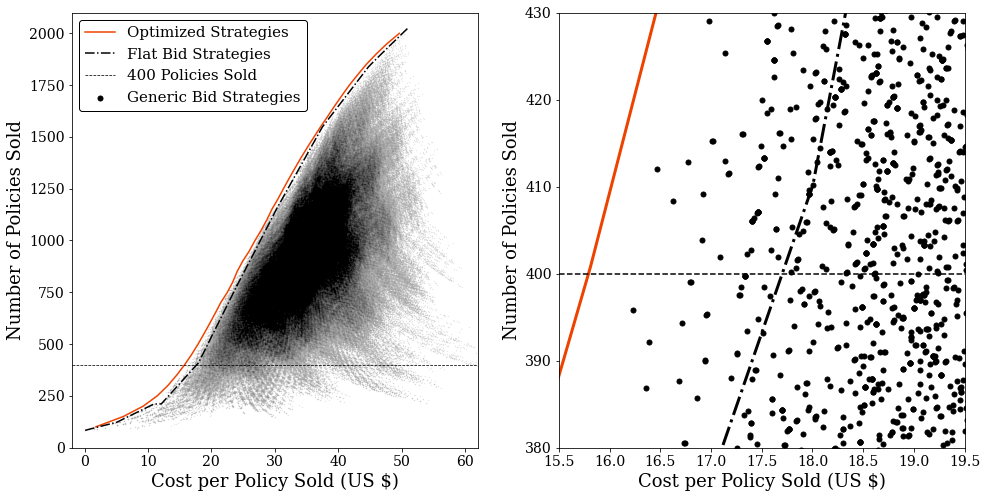

In [18]:
plt.figure(figsize=(16,8))

#Plot full space
plt.subplot(1,2,1)

#putting a point off in the middle of nowhere to have a visible entry in the legend
plt.scatter(500, 5000, color='k', label='Generic Bid Strategies', s=25)

plt.scatter(AdCosts, TotSales, color='0.8', s=0.025)
plt.scatter(AdCosts, TotSales, color='k', s=0.5, alpha=0.006)
plt.plot(RWAdCosts, RWTotSales, color=Orange120, label='Optimized Strategies', linewidth=1.5, linestyle='-')
plt.plot(ConstAdCosts, ConstTotSales, color='k', label='Flat Bid Strategies', linewidth=1.5, linestyle='-.')
plt.axhline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

plt.legend(fontsize=15,loc='upper left',framealpha=1.0,edgecolor='k')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-2.00,62.00)
plt.ylim(0,2100)

#Now zoom in around the 400 policies sold region
plt.subplot(1,2,2)

plt.scatter(AdCosts, TotSales, color='k', label='Generic Bid Strategies', s=25)
plt.plot(RWAdCosts, RWTotSales, color=Orange120, label='Optimized Strategies', linewidth=3.0, linestyle='-')
plt.plot(ConstAdCosts, ConstTotSales, color='k', label='Flat Bid Strategies', linewidth=3.0, linestyle='-.')
plt.axhline(400,color='k',linestyle='--',label='400 Policies Sold',linewidth=1.5)

#plt.legend(fontsize=15,loc='lower right',framealpha=1.0,edgecolor='k')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(15.50,19.50)
plt.ylim(380,430)

plt.show()

Not bad! We were able to find some additional savings over the flat-bid approach. Next we'll need to map from the compressed parameter space back onto the full parameter space for the final stage of our optimization.

In [19]:
#Let's do a few random walks to optimize a strategy that sells at least 400 policies
OptCompCost,OptCompSales,OptCompStrategy = RandomWalkers(SalesGoal=400,
                                                         NSteps=8000,
                                                         NWalks=3,
                                                         DistWidth=0.1,
                                                         cat_df=compressed_df,
                                                         printout=False)

print("The following bid strategy is expected to yield "+str(round(OptCompSales,1))+" policy sales, at a cost per policy of $"+str(round(OptCompCost,2))+"." )
print()

for i in range(len(OptCompStrategy)):
    CustomerInfo = compressed_df.iloc[i][["Insured","Vehicles","Drivers"]].values
    CustomerInfo = np.where(CustomerInfo == 23, '2/3', CustomerInfo)
    print("Insured: "+str(CustomerInfo[0]),'\t',
          "Vehicles: "+str(CustomerInfo[1]),'\t',
          "Drivers: "+str(CustomerInfo[2]),'\t',
          "Marital Status: "+"M/S",'\t',
          "Bid: $"+str(round(OptCompStrategy[i],2)),
         )

print()
print("This is where we will start our random walk in the full parameter space.")


The following bid strategy is expected to yield 400.0 policy sales, at a cost per policy of $15.79.

Insured: U/N 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $9.12
Insured: U/N 	 Vehicles: 1.0 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $8.0
Insured: Y 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $6.45
Insured: U/N 	 Vehicles: 2/3 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $6.2
Insured: U/N 	 Vehicles: 2/3 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $5.77
Insured: Y 	 Vehicles: 1.0 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $3.76
Insured: Y 	 Vehicles: 2/3 	 Drivers: 2.0 	 Marital Status: M/S 	 Bid: $0.01
Insured: Y 	 Vehicles: 2/3 	 Drivers: 1.0 	 Marital Status: M/S 	 Bid: $0.01

This is where we will start our random walk in the full parameter space.


In [20]:
#Next need to code up the matching between optimized bid strategies for the compressed parameters so we can
#feed them into the full parameter space and do another random walk sequence there, just in case there are
#some significant optimizations we're missing by only looking at the compressed space so far

FullRangeStartStrat = []

for i in range(len(categories_df)):
    FullCustomerInfo = categories_df.iloc[i][["Insured","Vehicles","Drivers"]].values
    if FullCustomerInfo[0] == 'N' or FullCustomerInfo[0] == 'unknown':
        FullCustomerInfo[0] = 'U/N'
    if FullCustomerInfo[1] == 2.0 or FullCustomerInfo[1] == 3.0:
        FullCustomerInfo[1] = '2/3'
    for j in range(len(OptimalStrategy)):
        CompressedCustomerInfo = compressed_df.iloc[j][["Insured","Vehicles","Drivers"]].values
        CompressedCustomerInfo = np.where(CompressedCustomerInfo == 23, '2/3', CompressedCustomerInfo)
        if list(CompressedCustomerInfo)==list(FullCustomerInfo):
            FullRangeStartStrat.append(OptCompStrategy[j])

In [21]:
#Now actually do the random walk in the full parameter space
#We'll want a large NSteps here since there are many more parameters
OptFullCost,OptFullSales,OptFullStrategy = RandomWalkers(SalesGoal=400,
                                                         NSteps=35000,
                                                         NWalks=3,
                                                         DistWidth=0.2,
                                                         cat_df=categories_df,
                                                         printout=False,
                                                         StartStrategy=FullRangeStartStrat,
                                                         StartCost=OptCompCost,
                                                         StartSales=OptCompSales)

print("The following bid strategy is expected to yield "+str(round(OptFullSales,1))+" policy sales, at a cost per policy of $"+str(round(OptFullCost,2))+"." )
print()

for i in range(len(OptFullStrategy)):
    FullCustomerInfo = categories_df.iloc[i][["Insured","Vehicles","Drivers","Marital Status"]].values
    print("Insured: "+str(FullCustomerInfo[0]),'\t',
          "Vehicles: "+str(FullCustomerInfo[1]),'\t',
          "Drivers: "+str(FullCustomerInfo[2]),'\t',
          "Marital Status: "+str(FullCustomerInfo[3]),'\t',
          "Bid: $"+str(round(FullRangeStartStrat[i],2)),
         )


The following bid strategy is expected to yield 400.1 policy sales, at a cost per policy of $14.87.

Insured: N 	 Vehicles: 3.0 	 Drivers: 1.0 	 Marital Status: M 	 Bid: $6.2
Insured: N 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: S 	 Bid: $9.12
Insured: N 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M 	 Bid: $9.12
Insured: unknown 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: S 	 Bid: $9.12
Insured: unknown 	 Vehicles: 1.0 	 Drivers: 2.0 	 Marital Status: M 	 Bid: $8.0
Insured: unknown 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: M 	 Bid: $9.12
Insured: N 	 Vehicles: 3.0 	 Drivers: 2.0 	 Marital Status: M 	 Bid: $5.77
Insured: unknown 	 Vehicles: 2.0 	 Drivers: 1.0 	 Marital Status: M 	 Bid: $6.2
Insured: Y 	 Vehicles: 1.0 	 Drivers: 1.0 	 Marital Status: S 	 Bid: $6.45
Insured: N 	 Vehicles: 2.0 	 Drivers: 2.0 	 Marital Status: S 	 Bid: $5.77
Insured: N 	 Vehicles: 2.0 	 Drivers: 2.0 	 Marital Status: M 	 Bid: $5.77
Insured: unknown 	 Vehicles: 3.0 	 Drivers: 2.0 	 Mar

Fantastic! That would give us a nearly 40% savings compared to the \\\$23.98 cost per policy sold that the current flat \\\$10 bid strategy yields.

Let's finish our analysis by examining what the full range of optimized models looks like, since this is a valuable resource for Acme and an important visual we can use to explain the potential value of performing an experiment during the next ad campaign to measure the average bid increase needed to improve an ad's display rank.

In [22]:
TestGoals = [100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,
             1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]

RWAdCosts = []
RWTotSales = []

for TestGoal in TestGoals:
    #First do a random walk in the compressed space after starting from the curve of flat bidding
    OptCompCost,OptCompSales,OptCompStrategy = RandomWalkers(SalesGoal=TestGoal,
                                                             NSteps=5000,
                                                             NWalks=3,
                                                             DistWidth=0.2,
                                                             cat_df=compressed_df,
                                                             printout=False)
    
    #Now map the result of this random walk onto the full parameter space
    FullRangeStartStrat = []
    for i in range(len(categories_df)):
        FullCustomerInfo = categories_df.iloc[i][["Insured","Vehicles","Drivers"]].values
        #print(FullCustomerInfo)
        if FullCustomerInfo[0] == 'N' or FullCustomerInfo[0] == 'unknown':
            FullCustomerInfo[0] = 'U/N'
        if FullCustomerInfo[1] == 2.0 or FullCustomerInfo[1] == 3.0:
            FullCustomerInfo[1] = '2/3'
        for j in range(len(OptimalStrategy)):
            CompressedCustomerInfo = compressed_df.iloc[j][["Insured","Vehicles","Drivers"]].values
            CompressedCustomerInfo = np.where(CompressedCustomerInfo == 23, '2/3', CompressedCustomerInfo)
            if list(CompressedCustomerInfo)==list(FullCustomerInfo):
                #print(FullCustomerInfo,CompressedCustomerInfo,OptCompStrategy[j])
                FullRangeStartStrat.append(OptCompStrategy[j])
    
    #Get a fully* optimized strategy by taking a long walk in the full parameter space
    #*modulo the fact that we're probably leaving a few cents or so of efficiency on the table
    #by not running for some insane number of steps
    OptFullCost,OptFullSales,OptFullStrategy = RandomWalkers(SalesGoal=TestGoal,
                                                             NSteps=25000,
                                                             NWalks=1,
                                                             DistWidth=0.2,
                                                             cat_df=categories_df,
                                                             printout=False,
                                                             StartStrategy=FullRangeStartStrat,
                                                             StartCost=OptCompCost,
                                                             StartSales=OptCompSales)
    
    RWAdCosts.append(OptFullCost)
    RWTotSales.append(OptFullSales)

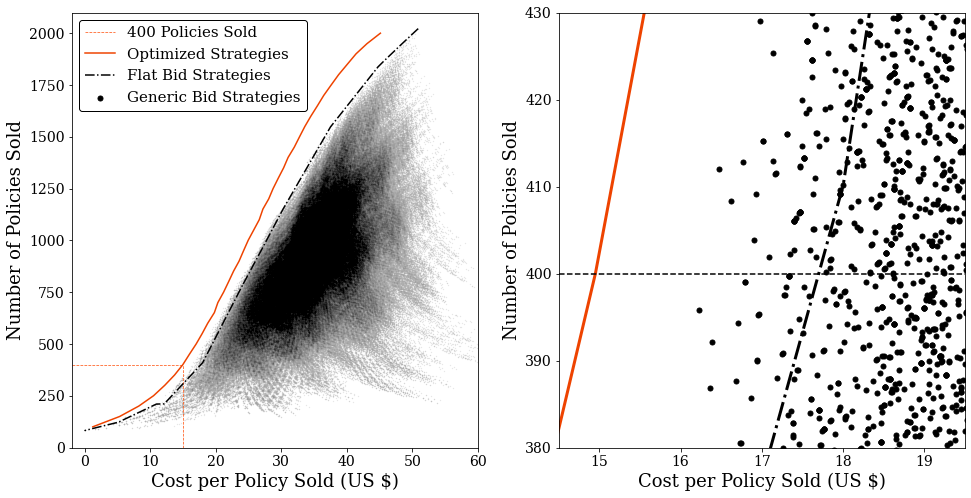

In [23]:
plt.figure(figsize=(16,8))

#Plot full space
plt.subplot(1,2,1)

#putting a point off in the middle of nowhere to have a visible entry in the legend
plt.scatter(500, 5000, color='k', label='Generic Bid Strategies', s=25)

#Get location of the 400 policies sold optimized bid strategy for including nice lines in the plot
opt_ind = [i for i,x in enumerate(RWTotSales) if x>400][0]
plt.axvline(RWAdCosts[opt_ind],
            ymax=(RWTotSales[opt_ind]-0.0)/(2100-0.0), 
            linewidth=0.75,color=RootOrange,linestyle='--')
plt.axhline(RWTotSales[opt_ind],
            xmax=(RWAdCosts[opt_ind]-(-2.0))/(60-(-2.0)),
            label='400 Policies Sold',
            linewidth=0.75,color=RootOrange,linestyle='--')

plt.scatter(AdCosts, TotSales, color='0.8', s=0.025)
plt.scatter(AdCosts, TotSales, color='k', s=0.5, alpha=0.006)
plt.plot(RWAdCosts, RWTotSales, color=Orange120, label='Optimized Strategies', linewidth=1.5, linestyle='-')
plt.plot(ConstAdCosts, ConstTotSales, color='k', label='Flat Bid Strategies', linewidth=1.5, linestyle='-.')

plt.legend(fontsize=15,loc='upper left',framealpha=1.0,edgecolor='k')
plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-2.00,60.00)
plt.ylim(0,2100)

#Now zoom in around the 400 policies sold region
plt.subplot(1,2,2)

plt.scatter(AdCosts, TotSales, color='k', label='Generic Bid Strategies', s=25)
plt.plot(RWAdCosts, RWTotSales, color=Orange120, label='Optimized Strategies', linewidth=3.0, linestyle='-')
plt.plot(ConstAdCosts, ConstTotSales, color='k', label='Flat Bid Strategies', linewidth=3.0, linestyle='-.')
plt.axhline(400,color='k',linestyle='--',label='400 Policies Sold',linewidth=1.5)

plt.xlabel('Cost per Policy Sold (US \$)', fontsize=18)
plt.ylabel('Number of Policies Sold', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(14.50,19.50)
plt.ylim(380,430)

plt.show()

Thus, we are able to produce some significant improvements in cost efficiency through this series of random walks.

If our assumption about how increasing bid prices maps onto improved ranks is valid, the orange curve shown above would be an extremely powerful tool for Acme to use in future marketing decisions. As it stands, there is of course significant uncertainty (and no direct way to measure) whether the assumption is valid. However, for future ad campaigns it would likely be feasible to set aside a portion of the ads to use as an experiment from which we would be able to directly estimate a true number for the RankValue parameter we have been using.

It would also be relatively easy to modify the code in this notebook to accomadate a nonlinear response to increasing bids. I.e., if it costs less to move an ad from rank 5 to rank 4 than it does to move it from rank 2 to rank 1. We would simply need a sufficiently large experimental subset in the next ad campaign to identify and characterize such a relation.